In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, BatchNormalization,
                                     LeakyReLU, Dropout, GaussianNoise)
import joblib
import os

# ------------------------
# Configuration
# ------------------------
DATA_PATH = '/content/drive/MyDrive/IDS/data/combined_dataset.csv'
MODEL_DIR = '/content/drive/MyDrive/IDS/models'
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------
# Load and Preprocess Data
# ------------------------
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()
label_col = 'Label' if 'Label' in df.columns else ' Label'
labels = df[label_col]
features = df.drop(columns=[label_col])

features = features.select_dtypes(include=[np.number])
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)
labels = labels.loc[features.index]

X = features.astype(np.float32).values
y = np.where(labels == 'BENIGN', 0, 1)

# Split only on benign data
X_benign = X[y == 0]
X_attack = X[y == 1]

X_train, X_val = train_test_split(X_benign, test_size=0.2, random_state=42)
X_test = np.concatenate([X_val, X_attack])
y_test = np.concatenate([np.zeros(len(X_val)), np.ones(len(X_attack))])

# Shuffle test set
shuffle = np.random.permutation(len(X_test))
X_test, y_test = X_test[shuffle], y_test[shuffle]

# ------------------------
# Standard Scaling
# ------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ------------------------
# Build Autoencoder
# ------------------------
input_dim = X_train_scaled.shape[1]
model = Sequential([
    Input(shape=(input_dim,)),
    GaussianNoise(0.01),

    Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(), LeakyReLU(0.05),

    Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(), LeakyReLU(0.05),

    Dropout(0.2),
    Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(), LeakyReLU(0.05), Dropout(0.2),

    Dense(32), BatchNormalization(), LeakyReLU(0.05), Dropout(0.2),
    Dense(64), BatchNormalization(), LeakyReLU(0.05),

    Dense(input_dim, activation='linear')
])

def hybrid_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    mae = tf.reduce_mean(tf.abs(y_true - y_pred), axis=-1)
    return 0.7 * mse + 0.3 * mae

model.compile(optimizer='adam', loss=hybrid_loss)

# ------------------------
# Train Model
# ------------------------
model.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=120,
    batch_size=64,
    verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]
)

# ------------------------
# Evaluate
# ------------------------
recon_val = model.predict(X_val_scaled, verbose=0)
val_errors = hybrid_loss(X_val_scaled, recon_val).numpy()
threshold = np.percentile(val_errors, 95)

recon_test = model.predict(X_test_scaled, verbose=0)
test_errors = hybrid_loss(X_test_scaled, recon_test).numpy()
y_pred = (test_errors > threshold).astype(int)

print("\n[RESULTS]\n", classification_report(y_test, y_pred, digits=4))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AE Threshold (95th percentile): {threshold:.6f}")

# ------------------------
# Save Artifacts
# ------------------------
model.save(os.path.join(MODEL_DIR, 'autoencoder_tf.keras'))
joblib.dump(scaler, os.path.join(MODEL_DIR, 'ae_scaler.pkl'))
print("[INFO] Model and scaler saved.")


In [ ]:
# ------------------------ Imports ------------------------ #
import numpy as np
import pandas as pd
from sklearn.svm             import SVC
from sklearn.calibration      import CalibratedClassifierCV
from sklearn.model_selection  import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics          import (classification_report,
                                      roc_auc_score,
                                      brier_score_loss)
from sklearn.utils            import shuffle
import joblib

# ------------------------ Helper: proportional sampler ------------------------ #
def balanced_proportional_sample(X, y,
                                 total_samples=100_000,
                                 rare_class_threshold=100,
                                 random_state=42):
    """
    Keeps **all** rows for classes that have < rare_class_threshold.
    Fills the remaining slots proportionally from common classes.
    """
    np.random.seed(random_state)
    classes, counts = np.unique(y, return_counts=True)

    rare_classes   = classes[counts < rare_class_threshold]
    non_rare       = classes[counts >= rare_class_threshold]

    # Initialize X_keep and y_keep
    X_keep = np.empty((0, X.shape[1]))
    y_keep = np.empty(0)

    # Concat all rare rows if there are any
    if len(rare_classes) > 0:
        X_keep = np.vstack([X[y == c] for c in rare_classes])
        y_keep = np.concatenate([y[y == c] for c in rare_classes])

    rare_cnt = len(y_keep)
    slots_left = total_samples - rare_cnt
    if slots_left <= 0:
        # If total_samples is less than or equal to the count of rare samples,
        # just shuffle the rare samples (or all samples if no rare classes)
        if len(rare_classes) == len(classes): # Only rare classes exist
             return shuffle(X_keep, y_keep, random_state=random_state)
        else: # Rare classes exist, and total_samples <= rare_cnt
            return shuffle(X_keep, y_keep, random_state=random_state)[:total_samples] # Take only up to total_samples

    # proportional fill from non‑rare (or all classes if no rare classes)
    classes_to_sample_from = non_rare if len(rare_classes) > 0 else classes
    counts_to_sample_from = {c: (y == c).sum() for c in classes_to_sample_from}
    total_to_sample_from = sum(counts_to_sample_from.values())

    X_extra, y_extra = [], []
    if total_to_sample_from > 0: # Avoid division by zero if there are no classes to sample from
        for cls in classes_to_sample_from:
            take = int(slots_left * (counts_to_sample_from[cls] / total_to_sample_from))
            # Ensure we don't try to sample more rows than exist
            rows_to_choose_from = np.where(y == cls)[0]
            num_rows_to_choose = min(take, len(rows_to_choose_from))

            # Only attempt sampling if there are rows available and we need to take some
            if num_rows_to_choose > 0:
                rows = np.random.choice(rows_to_choose_from,
                                        size=num_rows_to_choose,
                                        replace=False)
                X_extra.append(X[rows])
                y_extra.append(y[rows])

    # Combine keep and extra samples
    if len(X_extra) > 0:
        X_out = np.vstack([X_keep] + X_extra)
        y_out = np.concatenate([y_keep] + y_extra)
    else:
        X_out = X_keep
        y_out = y_keep

    # Ensure the final sample size does not exceed total_samples
    if len(y_out) > total_samples:
         # This case should ideally not happen with the logic, but as a safeguard
         shuffle_idx = np.random.permutation(len(y_out))[:total_samples]
         X_out = X_out[shuffle_idx]
         y_out = y_out[shuffle_idx]
    else:
         # Shuffle the final output
         X_out, y_out = shuffle(X_out, y_out, random_state=random_state)


    return X_out, y_out

# ------------------------ 1. Load full 87‑feature dataset ------------------------ #
X_full = np.load('/content/drive/MyDrive/IDS/processed/X_87_full.npy')
y_full_df = pd.read_csv('/content/drive/MyDrive/IDS/processed/y_full_labels.csv')
y_full_raw = y_full_df['Label'].astype(str).str.strip().values

# Binary label: 0 = BENIGN, 1 = ATTACK
y_bin = np.where(y_full_raw == 'BENIGN', 0, 1)

# ------------------------ 2. Down‑sample (balanced) ------------------------ #
X_smpl, y_smpl = balanced_proportional_sample(
    X_full, y_bin,
    total_samples=100_000,
    rare_class_threshold=100,
    random_state=42
)
print("Sampled shape:", X_smpl.shape, "Benign:", (y_smpl==0).sum(),
      "Attack:", (y_smpl==1).sum())

# ------------------------ 3. Train / test split ------------------------ #
X_tr, X_te, y_tr, y_te = train_test_split(
    X_smpl, y_smpl,
    test_size=0.2,
    stratify=y_smpl,
    random_state=42
)

# ------------------------ 4. Class‑balanced weights ------------------------ #
weights = compute_sample_weight(class_weight='balanced', y=y_tr)

# ------------------------ 5. RBF SVM + 5‑fold calibration ------------------------ #
base_svm = SVC(kernel='rbf',
               C=1.0,
               gamma='scale',
               class_weight='balanced',
               probability=True,
               random_state=42)

svm_cal = CalibratedClassifierCV(base_svm, cv=5)
svm_cal.fit(X_tr, y_tr, sample_weight=weights)

# ------------------------ 6. Evaluation ------------------------ #
y_pred   = svm_cal.predict(X_te)
y_proba  = svm_cal.predict_proba(X_te)[:, 1]

print("\n── Calibrated SVM report ──")
print(classification_report(y_te, y_pred, target_names=['BENIGN', 'ATTACK']))
print("ROC‑AUC :", round(roc_auc_score(y_te, y_proba), 4))
print("Brier   :", round(brier_score_loss(y_te, y_proba), 4))

# ------------------------ 7. Save model ------------------------ #
joblib.dump(svm_cal, '/content/drive/MyDrive/IDS/models/svm_calibrated.pkl')
print("✅ Calibrated SVM saved → svm_calibrated.pkl")

Sampled shape: (99999, 87) Benign: 80318 Attack: 19681

── Calibrated SVM report ──
              precision    recall  f1-score   support

      BENIGN       1.00      0.89      0.94     16064
      ATTACK       0.69      0.99      0.81      3936

    accuracy                           0.91     20000
   macro avg       0.84      0.94      0.88     20000
weighted avg       0.94      0.91      0.92     20000

ROC‑AUC : 0.9886
Brier   : 0.0615
✅ Calibrated SVM saved → svm_calibrated.pkl


Attack classes (14): ['Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack � Brute Force' 'Web Attack � Sql Injection'
 'Web Attack � XSS']
Attack train 333933 | val 111311 | test 111312
SMOTE strategy: {'Web Attack � Brute Force': 1000, 'Web Attack � XSS': 1000, 'Infiltration': 1000, 'Web Attack � Sql Injection': 1000, 'Heartbleed': 1000}
After SMOTE: {3: 138074, 9: 95282, 1: 76815, 2: 6176, 6: 4761, 10: 3538, 5: 3477, 4: 3299, 0: 1174, 11: 1000, 13: 1000, 8: 1000, 12: 1000, 7: 1000}
[0]	train-mlogloss:2.01868	val-mlogloss:1.98000
[20]	train-mlogloss:0.27102	val-mlogloss:0.19800
[40]	train-mlogloss:0.09597	val-mlogloss:0.03118
[60]	train-mlogloss:0.06173	val-mlogloss:0.00808
[80]	train-mlogloss:0.04766	val-mlogloss:0.00477
[100]	train-mlogloss:0.03927	val-mlogloss:0.00427
[120]	train-mlogloss:0.03328	val-mlogloss:0.00420
[138]	train-mlogloss:0.02895	val-mlogloss:0.00427

Classificati

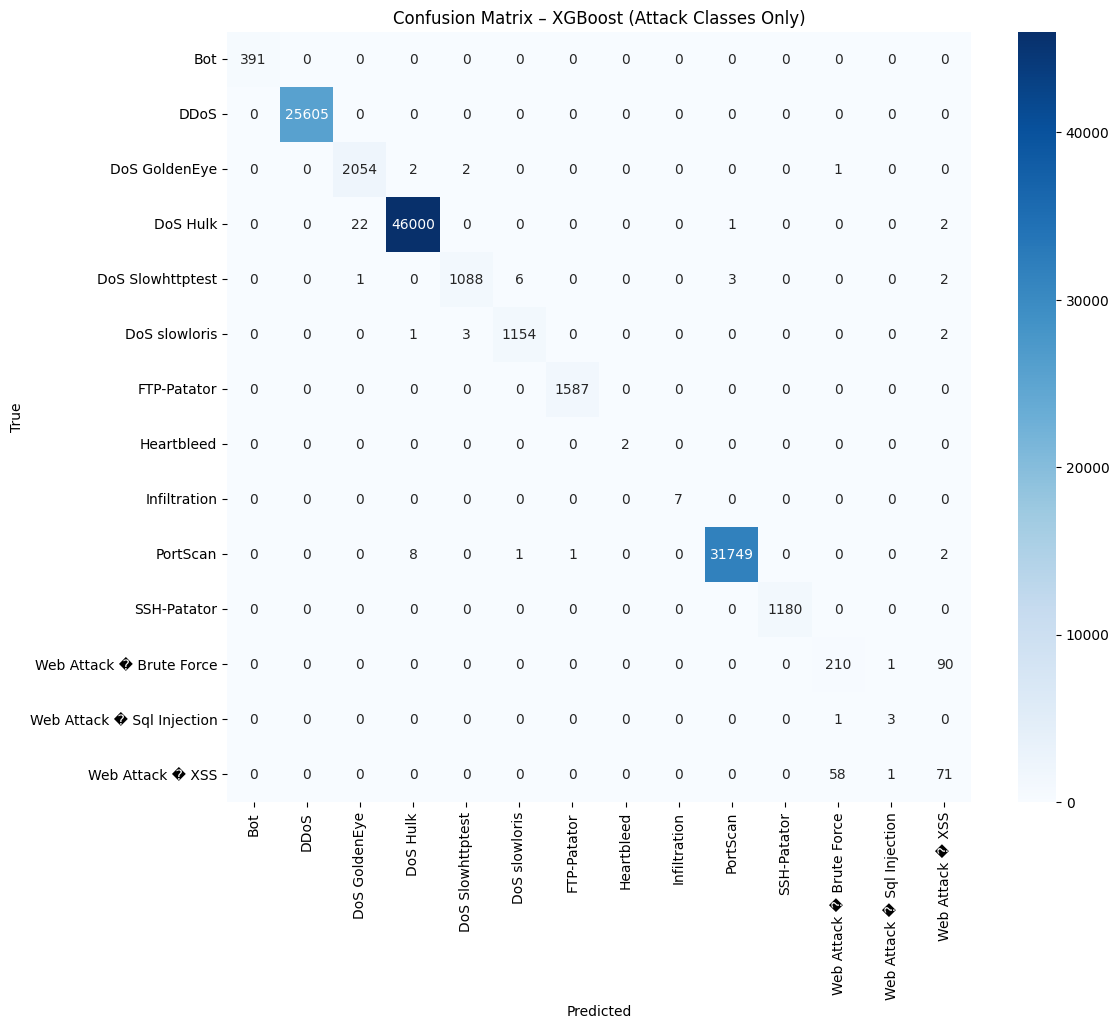

✅ Attack-only XGBoost model and label encoder saved.


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load full data (features + labels)
X_full = np.load('/content/drive/MyDrive/IDS/processed/X_87_full.npy')
y_full = pd.read_csv('/content/drive/MyDrive/IDS/processed/y_full_labels.csv')['Label'].astype(str).str.strip().values

# Filter out BENIGN, keep only attack samples
attack_mask = y_full != "BENIGN"
X_attack = X_full[attack_mask]
y_attack = y_full[attack_mask]

# Encode only attack classes
le_attack = LabelEncoder().fit(y_attack)
y_attack_enc = le_attack.transform(y_attack)
print(f"Attack classes ({len(le_attack.classes_)}): {le_attack.classes_}")

# Stratified split: train 60%, val 20%, test 20%
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_attack, y_attack_enc, test_size=0.4, random_state=42, stratify=y_attack_enc
)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)
print(f"Attack train {len(y_tr)} | val {len(y_val)} | test {len(y_te)}")

# SMOTE oversampling on rare attack classes in training set
class_counts = pd.Series(y_tr).value_counts()
strategy = {cls: 1000 for cls, cnt in class_counts.items() if cnt < 1000}
if strategy:
    print("SMOTE strategy:", {le_attack.classes_[k]: v for k, v in strategy.items()})
    sm = SMOTE(random_state=42, sampling_strategy=strategy)
    X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
    print("After SMOTE:", pd.Series(y_tr).value_counts().to_dict())

# Create DMatrix for XGBoost
sample_w = compute_sample_weight("balanced", y_tr)
dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sample_w)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_te, label=y_te)

# XGBoost parameters
params = {
    "objective": "multi:softprob",
    "num_class": len(le_attack.classes_),
    "eval_metric": "mlogloss",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
}

evals = [(dtrain, "train"), (dval, "val")]

# Train XGBoost model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=20,
)

# Evaluate on test set
y_pred = np.argmax(model.predict(dtest), axis=1)
print("\nClassification report on attack test set:")
print(classification_report(y_te, y_pred, target_names=le_attack.classes_))

# Plot confusion matrix (optional)
cm = confusion_matrix(y_te, y_pred, labels=np.arange(len(le_attack.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le_attack.classes_, yticklabels=le_attack.classes_,
            cmap="Blues")
plt.title("Confusion Matrix – XGBoost (Attack Classes Only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save model and label encoder
model.save_model('/content/drive/MyDrive/IDS/models/xgb_attack_only.json')
joblib.dump(le_attack, '/content/drive/MyDrive/IDS/models/label_encoder_attack_only.pkl')
print("✅ Attack-only XGBoost model and label encoder saved.")


Length of X: 2827876
Length of y: 2827876


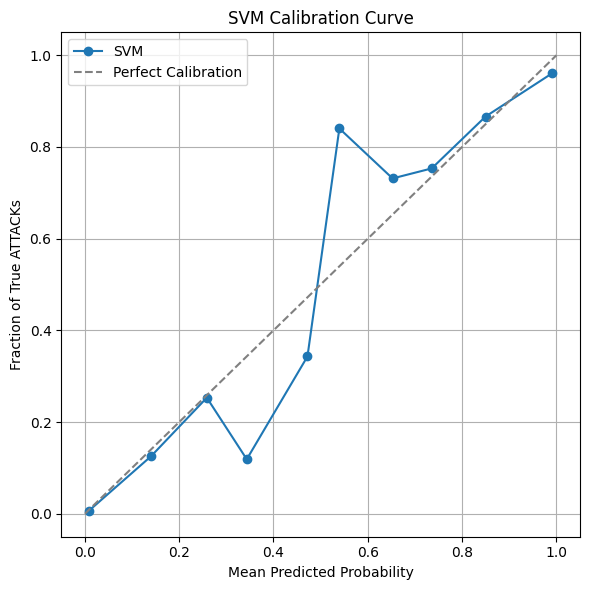

✅ Brier Score: 0.0520


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import joblib
import pandas as pd # Import pandas to read the label CSV consistently

# Load your data and model
# Load X using the .npy file
X = np.load("/content/drive/MyDrive/IDS/processed/X_87_full.npy")

# Load labels using the .csv file and ensure it's processed identically to how
# it was when saving the features, to maintain sample consistency.
# Assuming 'Label' is the column name in the CSV.
y_full_df = pd.read_csv("/content/drive/MyDrive/IDS/processed/y_full_labels.csv")
# Ensure labels match the cleaned features - assuming y_full_df already corresponds to X
y_raw = y_full_df['Label'].values

# Convert raw labels to binary (0 for BENIGN, 1 for ATTACK)
y = np.array([0 if lbl.strip() == "BENIGN" else 1 for lbl in y_raw])

# Double-check lengths before splitting
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")

# Ensure lengths are consistent before proceeding
if len(X) != len(y):
    raise ValueError("Inconsistent sample lengths between features (X) and labels (y).")

# Load trained SVM model
svm = joblib.load("/content/drive/MyDrive/IDS/models/svm_calibrated.pkl")

# Sample a subset (adjust size if needed)
# Now that X and y have consistent lengths, train_test_split will work.
X_sample, _, y_sample, _ = train_test_split(
    X, y, test_size=0.95, stratify=y, random_state=42
)

# Predict probabilities
y_prob = svm.predict_proba(X_sample)[:, 1]

# Plot calibration curve
# Check if y_sample and y_prob have the same number of samples before plotting
if len(y_sample) != len(y_prob):
    print(f"Warning: y_sample ({len(y_sample)}) and y_prob ({len(y_prob)}) have different lengths.")
    # Handle this case, maybe resample y_prob or skip plotting
    # For this fix, we assume they should be the same after sampling from consistent X, y

prob_true, prob_pred = calibration_curve(y_sample, y_prob, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='SVM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of True ATTACKs')
plt.title('SVM Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Brier score (lower is better)
brier = brier_score_loss(y_sample, y_prob)
print(f"✅ Brier Score: {brier:.4f}")